<a href="https://colab.research.google.com/github/Furankyyy/CS146-Modern-Computational-Statistics/blob/master/CS146_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS146 Final Project

Download data.

In [0]:
!wget https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv

--2019-12-25 19:18:46--  https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv
Resolving scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)... 169.228.224.138
Connecting to scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)|169.228.224.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63665 (62K) [text/csv]
Saving to: ‘weekly_in_situ_co2_mlo.csv’

weekly_in_situ_co2_ 100%[===================>]  62.17K  --.-KB/s    in 0.06s   

2019-12-25 19:18:46 (1.08 MB/s) - ‘weekly_in_situ_co2_mlo.csv’ saved [63665/63665]



In [0]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

### Data preprocessing

In [0]:
data = pd.read_csv('weekly_in_situ_co2_mlo.csv', skiprows=44, header=None, names=['Date','CO2'])
data

,Date,CO2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48
...,...,...
3134,2019-08-31,409.32
3135,2019-09-07,408.80
3136,2019-09-14,408.61
3137,2019-09-21,408.50


In [0]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

# Convert all dates to the number of days they are away from the beginning date.
start_date = data['Date'][0]
data['Time'] = data['Date'].map(lambda x: (x-start_date).days)

### Statistical Modeling

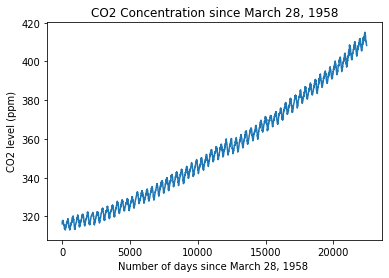

In [0]:
# Plot data.
plt.plot(data['Time'],data['CO2'])
plt.title('CO2 Concentration since March 28, 1958')
plt.xlabel('Number of days since March 28, 1958 ')
plt.ylabel('CO2 level (ppm)')
plt.show()

The data we have is time series data. In time-series modeling, we usually have an addictive model (Davis, 2014) with three components: trend, seasonal and noise.

$$X_t = Y_t + s_t+\sigma_t$$

where $Y_t$ is the trend component, $s_t$ the seasonal component, and $\sigma_t$ the random noise.

**Trend Component**

From the line plot of data, we can observe that CO2 level grows steadily with almost a linear trend. I have the assumption that the trend is linear, so I test this hypothesis by fitting a linear regression to the data.

I assume that the seasonal fluctuations is consistent and the noises will be cancelled out on average. Then, I fit a simple linear regression to the data.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


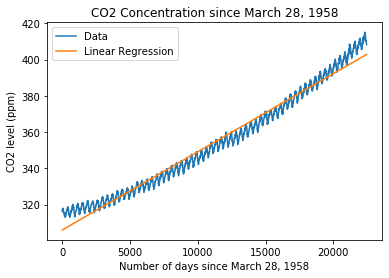


 R-squared: 0.9767721415997632 



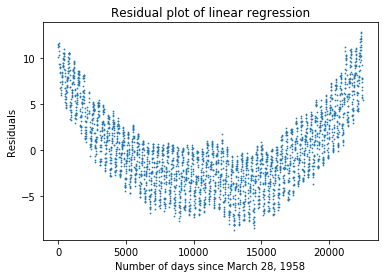

In [0]:
# Linear regression of data.
slope, intercept, r_value, p_value, std_err = sts.linregress(data['Time'],data['CO2'])

# Display results.

# Plot the regression line. 
plt.plot(data['Time'],data['CO2'],label='Data')
plt.plot(data['Time'],data['Time']*slope+intercept,label='Linear Regression')
plt.legend()
plt.title('CO2 Concentration since March 28, 1958')
plt.xlabel('Number of days since March 28, 1958')
plt.ylabel('CO2 level (ppm)')
plt.show()

# R^2.
print('\n','R-squared:',r_value**2,'\n')

# Residual plot.
residual_linear = data['CO2'] - (data['Time']*slope+intercept)
plt.scatter(data['Time'],residual_linear,s=0.5)
plt.title('Residual plot of linear regression')
plt.xlabel('Number of days since March 28, 1958')
plt.ylabel('Residuals')
plt.show()

Fitting a linear regression to the data shows that we obtain a very high $R^2$. However, if we visually inspect the regression line, we can see that the linear line does not fit the small and the large values of the x-variable. If we further plot the residuals, we can see that the residuals are not random. The curved shape of the residual plot shows that there is a non-linear trend in the data. We get higher residuals for small and large values of the x-variable and get low residuals for mid-range values. This suggests that we may need a quadratic trend.

Therefore, I try to fit a quadratic regression to the data.

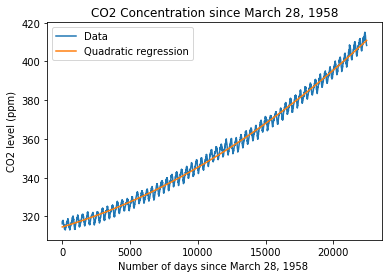


 R-squared: 0.9935481918093005 



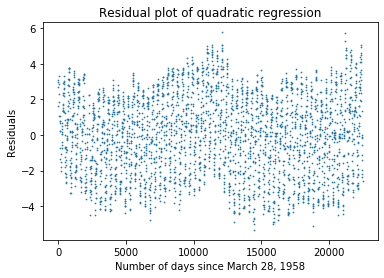

In [0]:
# Quadratic regression.
coef = np.polyfit(data['Time'],data['CO2'],2)

# Display results.

# Plot regression line
plt.plot(data['Time'],data['CO2'],label='Data')
plt.plot(data['Time'],coef[0]*data['Time']**2+data['Time']*coef[1]+coef[2],label='Quadratic regression')
plt.legend()
plt.title('CO2 Concentration since March 28, 1958')
plt.xlabel('Number of days since March 28, 1958 ')
plt.ylabel('CO2 level (ppm)')
plt.show()

# R-squared.
ss_tot = np.sum((data['CO2']-np.mean(data['CO2']))**2) # Total sum of squares
ss_res = np.sum((data['CO2']-(coef[0]*data['Time']**2+data['Time']*coef[1]+coef[2]))**2) # Residual sum of squares
print('\n','R-squared:',1-ss_res/ss_tot,'\n')
 
# Residual plot.
residual_quad = data['CO2']-(coef[0]*data['Time']**2+data['Time']*coef[1]+coef[2])
plt.scatter(data['Time'],residual_quad,s=0.5)
plt.title('Residual plot of quadratic regression')
plt.xlabel('Number of days since March 28, 1958')
plt.ylabel('Residuals')
plt.show()

I obtained a higher $R^2$ with quadratic regression, and the residual plot is more random than that of the linear regression. I am more confident now with the quadratic model. To make sure that the quadratic regression does not overfit the data, I used a hold out portion of data to test the predictability of the linear and the quadratic model.

In [0]:
# Split train and test data. Use first 80% of data as training and rest 20% as testing.
train_x = data['Time'][:round(len(data['Time'])*0.8)]
train_y = data['CO2'][:round(len(data['Time'])*0.8)]
test_x = data['Time'][round(len(data['Time'])*0.8):]
test_y = data['CO2'][round(len(data['Time'])*0.8):]

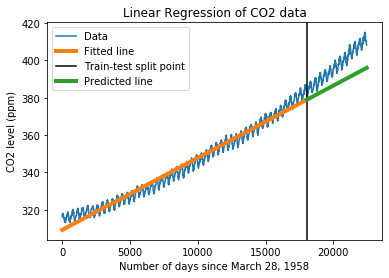


 Mean squared error of linear regression: 112.31816579462772 



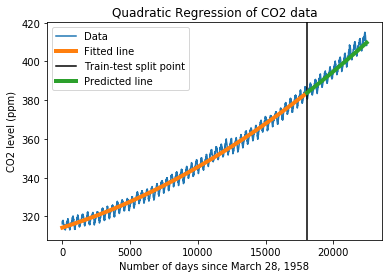


 Mean squared error of quadratic regression: 6.538507414300364


In [0]:
# Linear regression on the splitted data.

slope, intercept, r_value, p_value, std_err = sts.linregress(train_x,train_y)

# Predict test data
pred_y = test_x*slope + intercept

# Display results.

# Plot prediction.
plt.plot(data['Time'],data['CO2'],label='Data')
plt.plot(train_x,slope*train_x+intercept,label='Fitted line',linewidth=4)
plt.axvline(data['Time'][round(len(data['Time'])*0.8)],c='black',label='Train-test split point')
plt.plot(test_x,pred_y,label='Predicted line',linewidth=4)
plt.legend()
plt.title('Linear Regression of CO2 data')
plt.xlabel('Number of days since March 28, 1958') 
plt.ylabel('CO2 level (ppm)')
plt.show()

# Prediction error.
print('\n','Mean squared error of linear regression:',np.mean((test_y-pred_y)**2),'\n')


# Compare the above results with quadratic regression.

coef = np.polyfit(train_x,train_y,2)

# Predict results for quadratic regression.
pred_y2 = coef[0]*test_x**2+test_x*coef[1]+coef[2]

# Display results for quadratic regression.
plt.plot(data['Time'],data['CO2'],label='Data')
plt.plot(train_x,coef[0]*train_x**2+train_x*coef[1]+coef[2],label='Fitted line',linewidth=4)
plt.axvline(data['Time'][round(len(data['Time'])*0.8)],c='black',label='Train-test split point')
plt.plot(test_x,pred_y2,label='Predicted line',linewidth=4)
plt.legend()
plt.title('Quadratic Regression of CO2 data')
plt.xlabel('Number of days since March 28, 1958') 
plt.ylabel('CO2 level (ppm)')
plt.show()

# Prediction error for quadratic regression.
print('\n','Mean squared error of quadratic regression:',np.mean((test_y-pred_y2)**2))

The comparison between the performance of linear and quadratic regression on the test set data shows a much better result for quadratic regression. Visually it fits the true data better, and statistically it has a much lower mean squared error (6.5 versus 112.3).

**Seasonal Component**

To examine the seasonal trend, we can first plot it. Because then seasonal trend has a period of approximately a year, I first detrend the data by subtract them with the annual mean CO2 level of that year.

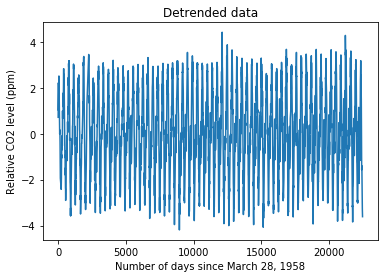

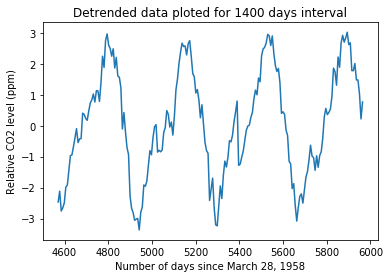

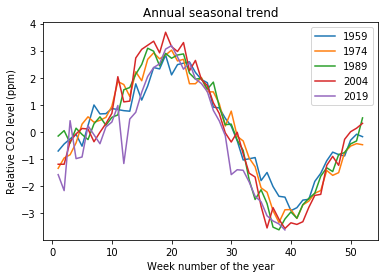

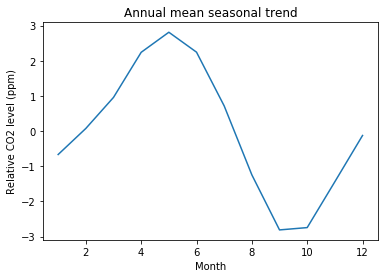

In [0]:
# Find detrended data.
data['Annual mean'] = data.groupby(data['Date'].dt.year)['CO2'].transform('mean')
data['Detrended'] = data['CO2'] - data['Annual mean']

# Plot the detrended data to observe seasonal trend.
plt.plot(data['Time'],data['Detrended'])
plt.title('Detrended data')
plt.xlabel('Number of days since March 28, 1958') 
plt.ylabel('Relative CO2 level (ppm)')
plt.show()

# Zoom in a bit to better observe the trend.
plt.plot(data['Time'][600:800],data['Detrended'][600:800]) # Choose 200 rows (approximately 4 years interval) to plot
plt.title('Detrended data ploted for 1400 days interval')
plt.xlabel('Number of days since March 28, 1958') 
plt.ylabel('Relative CO2 level (ppm)')
plt.show()

# Plot seasonal trend for every 15 years to examine whether they are consistent.
for year in range(1959,2020,15):
    plt.plot([x.isocalendar()[1] for x in data.groupby(data['Date'].dt.year).get_group(year)['Date']],
             data.groupby(data['Date'].dt.year).get_group(year)['Detrended'],label=str(year))
plt.legend()
plt.xlabel('Week number of the year')
plt.ylabel('Relative CO2 level (ppm)')
plt.title('Annual seasonal trend')
plt.show()

# Seasonal trend plot within in a year.
monthly_mean = data.groupby(data['Date'].dt.month)['Detrended'].mean() # Detrended mean CO2 level for each month
plt.plot(monthly_mean)
plt.title('Annual mean seasonal trend')
plt.xlabel('Month')
plt.ylabel('Relative CO2 level (ppm)')
plt.show()


Now that we have plotted the seasonality. We can see that the period roughly aligns with our calendar system, which means that the period of the function is around one year. To model the seasonality, we can use a periodic function like sine or cosine. However, if we look at hte annual mean seasonal trend, we can see that it is not perfectly fitted by a single sine/cosine function. The adjusted CO2 level reaches 0 at around July, meaning that we have two different "bumps" (in terms of size) during the year. To model the seasonality more accurately, we can use Fourier transformation to approximate the true function.

Model seasonality:
$$s_t=\frac{a_0}{2}+\sum^{N}_{n=1}[a_n\cos(\frac{2\pi}{T}nt+c_n)+b_n\sin(\frac{2\pi}{T}nt+d_n)]$$
where $T = 365.25$ and $N$ is the number of harmonics.

We can analytically solve two of these variables, $c_n$ and $d_n$, because we know that the data starts from March 29, 1958. If the annual trend starts with rellative CO2 value of 0, then we need to shift the phase of the function by 88 days.

To choose the optimal $N$, we can try different values to see how they fit the data. The analytical solution of variables $a_n$ and $b_n$ can be obtained by:
$$a_n = \frac{2}{n}\sum^{N}_{n=1}\cos(\frac{2\pi}{T}nt+c_n)$$
$$b_n = \frac{2}{n}\sum^{N}_{n=1}\sin(\frac{2\pi}{T}nt+d_n)$$

In [0]:
# Define functions for Fourier Series

def FourierSeries(y, N, T, t, phi):
    """
    Calculate the Fourier series coefficients up to the Nth harmonic
    ---
    y: data
    N: N-th harmonic
    T: period
    t: x data (sampling frequencies)
    """

    result = []
    for n in range(N+1):
        an = 2/T*(y * np.cos(2*np.pi*n*(t+phi)/T)).sum()
        bn = 2/T*(y * np.sin(2*np.pi*n*(t+phi)/T)).sum()
        result.append((an, bn))
    return np.array(result)


def reconstruct(T, coef,t,phi):
    """
    Reconstruct the function from coefficients of Fourier seires
    ---
    T: period
    coef: array of a_n and b_n
    t: x data (sampling frequencies)

    """
    result = 0
    for n, (a, b) in enumerate(coef):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*(t+phi)/T) + b * np.sin(2*np.pi*n*(t+phi)/T)
    return result

I first use Fourier transformation on my detrended monthly mean data to observe a general fit. In this case, there is no phase shift because there are only 12 data points from Jan to Dec. I use values of $N$ from 1 to 5.

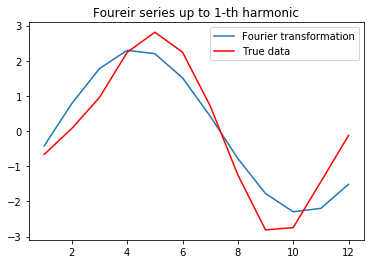

Mean squared error of Fourier series up to 1-th harmonic: 0.5173164074103997 



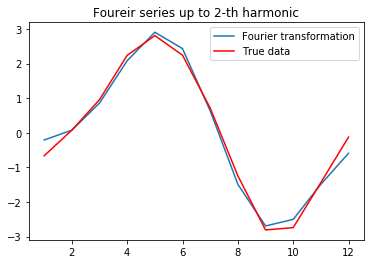

Mean squared error of Fourier series up to 2-th harmonic: 0.05368716356870465 



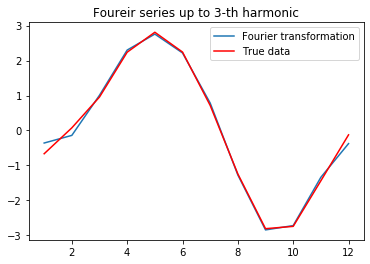

Mean squared error of Fourier series up to 3-th harmonic: 0.019210015690558847 



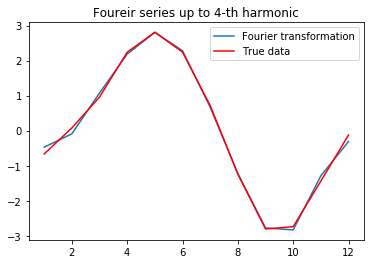

Mean squared error of Fourier series up to 4-th harmonic: 0.012595991636134958 



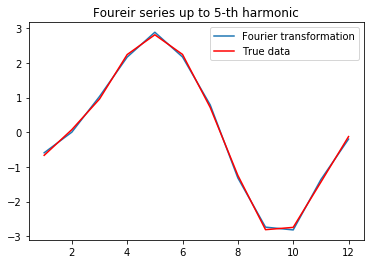

Mean squared error of Fourier series up to 5-th harmonic: 0.005335046984806964 



In [0]:
t = np.arange(1,13,1)#data['Time']
y = monthly_mean.values#data['Detrended']
T = 12

for n in range(1,6):
    Y = FourierSeries(y,n,T,t,0)
    plt.plot(t, reconstruct(T,Y,t,0),label='Fourier transformation')
    plt.plot(monthly_mean,c='red',label='True data')
    plt.title('Foureir series up to %d-th harmonic' %n)
    plt.legend()
    plt.show()

    print('Mean squared error of Fourier series up to %d-th harmonic:' %n,
          np.mean((y-reconstruct(T,Y,t,0))**2),
          '\n')

As expected, with more harmonics, the model can fit the data better. However, to prevent overfitting, we need to test the fit on some training data. Therefore, I move to the real dataset. For visualization convenience, I choose the first 500 rows (around 10 years of data) to obtain the coefficients of Fourier series and the next 500 rows to test the fit. I run the function through $N=1$ to $N=10$

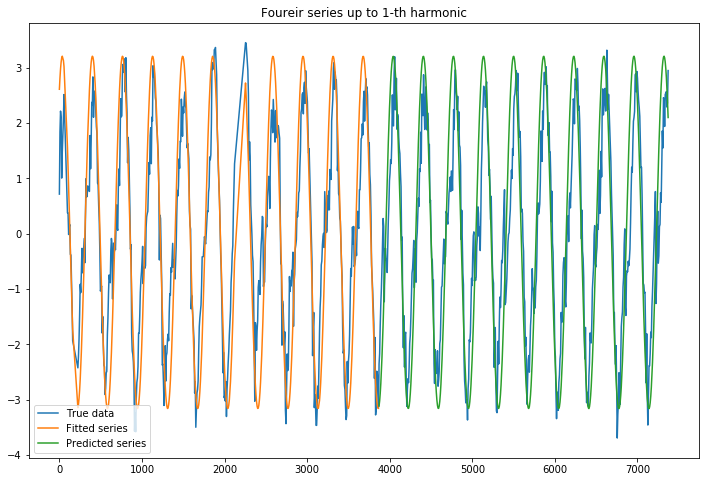

Train mean squared error of Fourier series up to 1-th harmonic: 0.9452217981844346
Test mean squared error of Fourier series up to 1-th harmonic: 1.0426924327961904 



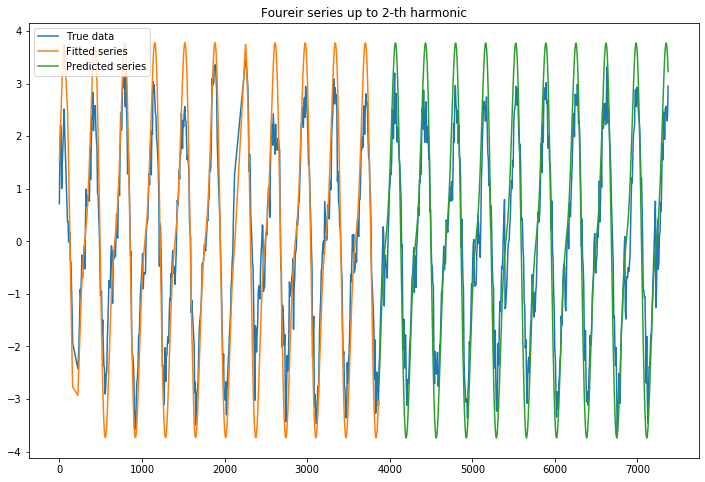

Train mean squared error of Fourier series up to 2-th harmonic: 0.6805579121786645
Test mean squared error of Fourier series up to 2-th harmonic: 0.7785557977318216 



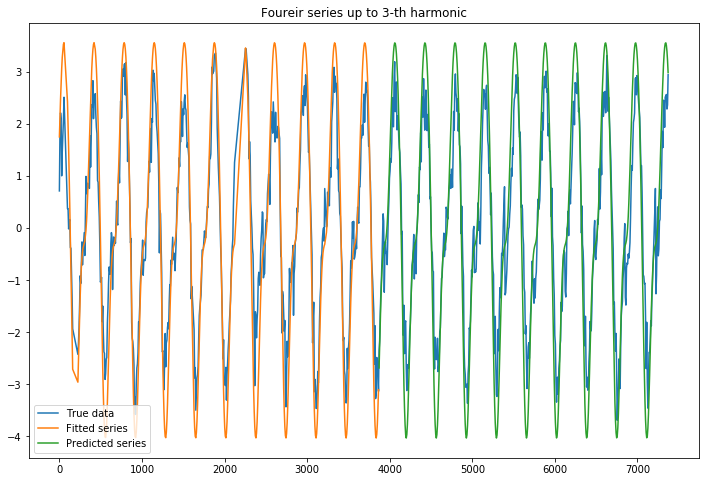

Train mean squared error of Fourier series up to 3-th harmonic: 0.6764330580187232
Test mean squared error of Fourier series up to 3-th harmonic: 0.7567822755393725 



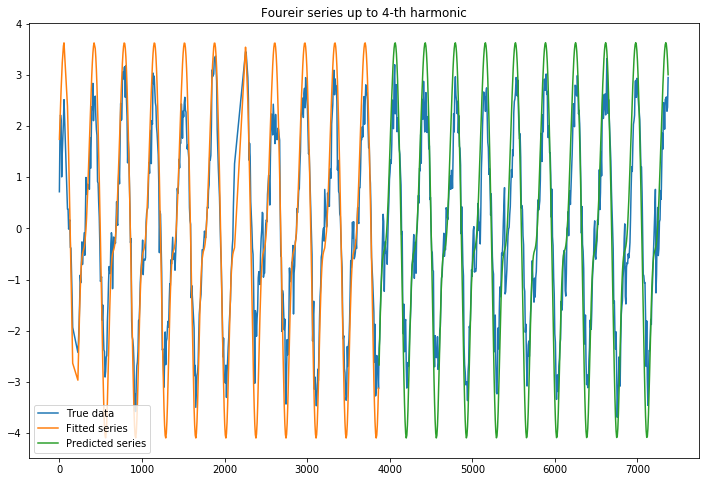

Train mean squared error of Fourier series up to 4-th harmonic: 0.6720414634880827
Test mean squared error of Fourier series up to 4-th harmonic: 0.755593567097093 



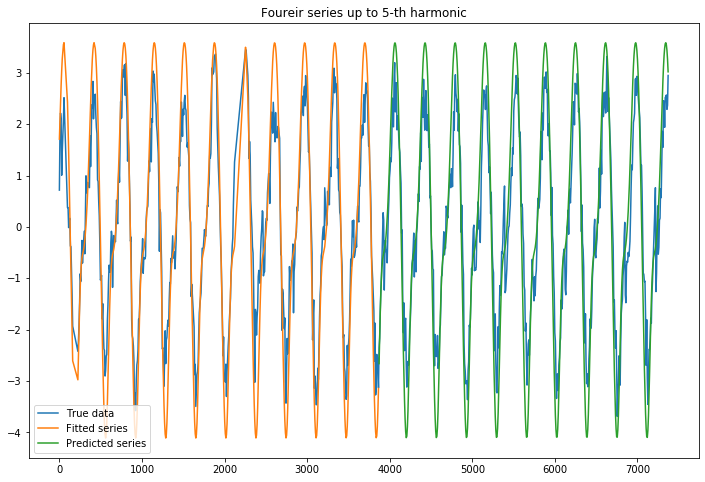

Train mean squared error of Fourier series up to 5-th harmonic: 0.6744316070350115
Test mean squared error of Fourier series up to 5-th harmonic: 0.7580757794773696 



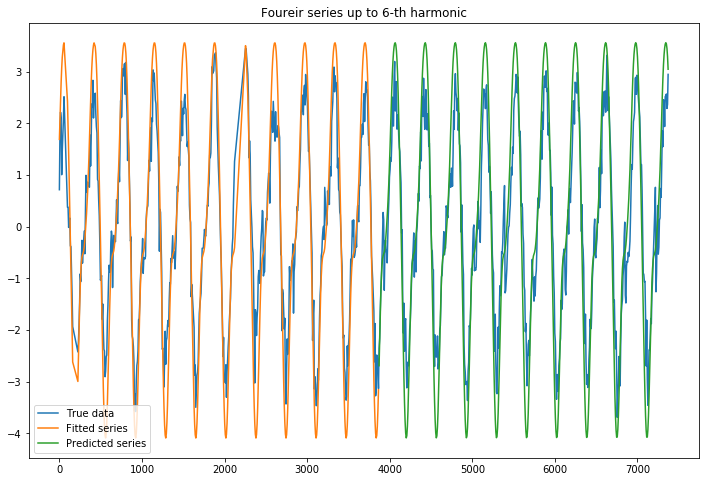

Train mean squared error of Fourier series up to 6-th harmonic: 0.6738451935603895
Test mean squared error of Fourier series up to 6-th harmonic: 0.7580136324372271 



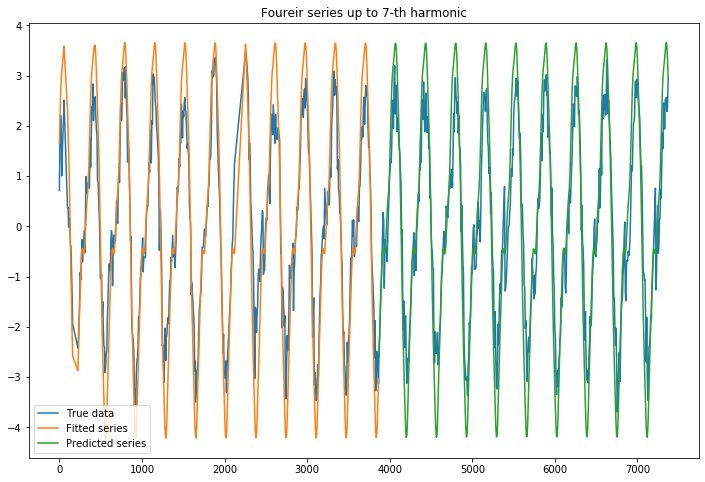

Train mean squared error of Fourier series up to 7-th harmonic: 0.6733714408691842
Test mean squared error of Fourier series up to 7-th harmonic: 0.7564608094031543 



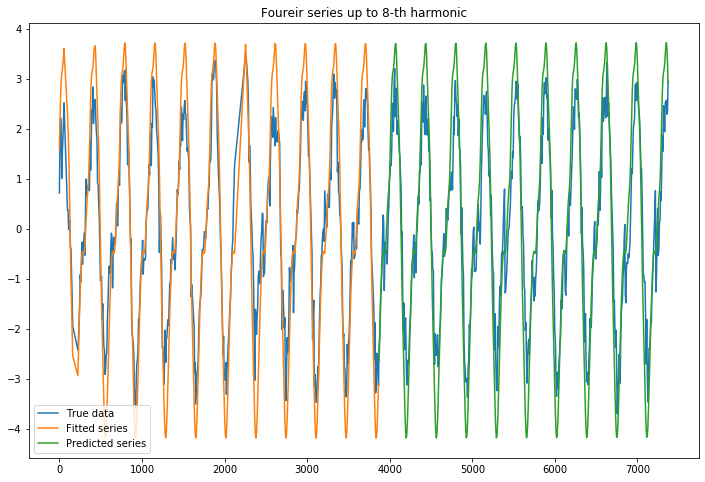

Train mean squared error of Fourier series up to 8-th harmonic: 0.674362217362234
Test mean squared error of Fourier series up to 8-th harmonic: 0.7591035871237802 



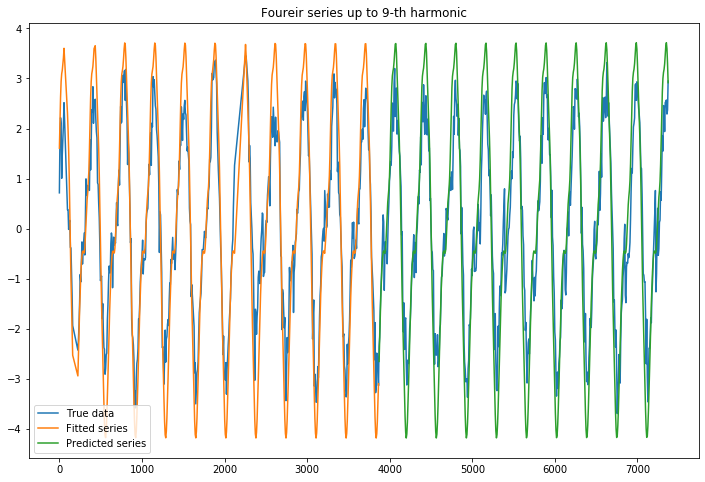

Train mean squared error of Fourier series up to 9-th harmonic: 0.6742569091492946
Test mean squared error of Fourier series up to 9-th harmonic: 0.7590766892542071 



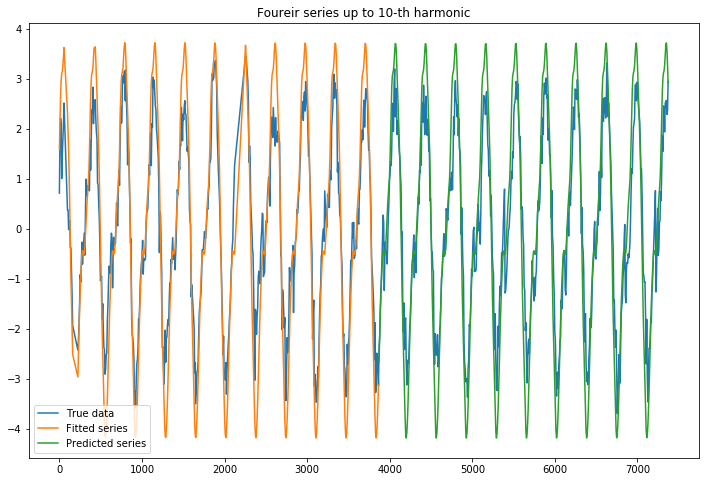

Train mean squared error of Fourier series up to 10-th harmonic: 0.674667850902498
Test mean squared error of Fourier series up to 10-th harmonic: 0.7602226486474563 



In [0]:
# Test Fourier series for first 500 rows of data and then test on the next 500 rows.
t = data['Time'][0:500]
y = data['Detrended'][0:500]
T = 364.25

for n in range(1,11):
    Y = FourierSeries(y,n,T,t,88)
    predt = data['Time'][500:1000]

    plt.figure(figsize=(12,8))
    plt.plot(data['Time'][0:1000],data['Detrended'][0:1000],label='True data')
    plt.plot(t, reconstruct(T,Y,t,88),label='Fitted series')
    plt.plot(predt,reconstruct(T,Y,predt,88),label='Predicted series')
    plt.title('Foureir series up to %d-th harmonic' %n)
    plt.legend()
    plt.show()

    print('Train mean squared error of Fourier series up to %d-th harmonic:'%n,
          np.mean((y-reconstruct(T,Y,t,88))**2))
    print('Test mean squared error of Fourier series up to %d-th harmonic:'%n,
          np.mean((data['Detrended'][500:1000]-reconstruct(T,Y,predt,88))**2),'\n')


**Noice Component**

**Model specification**



In [0]:
code = """

data {
    int<lower=0> num_data;
    real<lower=0> co2[num_data];  // number of recorded unit prices
    int<lower=0> day[num_data];
    real<lower=0> T; // period
    int<lower=0> n_future;

}

parameters { 
    real c0; // coefficient of the intercept in quadratic model
    real c1; // coefficient of the first degree component in quadratic model
    real <lower=0> c2; // coefficient of the second degree component in quadratic model

    // coefficient for Foureir series
    real a1;
    real a2;
    real a3;
    real b1;
    real b2;
    real b3;

    real <lower=0> sigma2; // noise component
}


model {
    sigma2 ~ cauchy(20,20);

    c0 ~ cauchy(300, 50);
    c1 ~ cauchy(0, 0.5);
    c2 ~ cauchy(0, 0.1);

    a1 ~ cauchy(0, 1);
    a2 ~ cauchy(0, 1);
    a3 ~ cauchy(0, 1);
    b1 ~ cauchy(0, 1);
    b2 ~ cauchy(0, 1);
    b3 ~ cauchy(0, 1);

    for (i in 1:num_data){
        
        co2[i] ~ normal(c0+c1*day[i]+c2*day[i]*day[i]+
                        a1*cos(2*pi()*(day[i]+88)/T)+b1*sin(2*pi()*(day[i]+88)/T)+
                        a2*cos(2*pi()*(day[i]+88)*2/T)+b2*sin(2*pi()*(day[i]+88)*2/T)+
                        a3*cos(2*pi()*(day[i]+88)*3/T)+b3*sin(2*pi()*(day[i]+88)*3/T),
                        sigma2); 
    }
}

generated quantities {
    real x_future[n_future];

    for(t in 1:n_future) {
    
        x_future[t] = normal_rng(c0+c1*(22463 + 7*t)+c2*(22463 + 7*t)*(22463 + 7*t)+
                        a1*cos(2*pi()*((22463 + 7*t)+88)/T)+b1*sin(2*pi()*((22463 + 7*t)+88)/T)+
                        a2*cos(2*pi()*((22463 + 7*t)+88)*2/T)+b2*sin(2*pi()*((22463 + 7*t)+88)*2/T)+
                        a3*cos(2*pi()*((22463 + 7*t)+88)*3/T)+b3*sin(2*pi()*((22463 + 7*t)+88)*3/T),
                        sigma2);
    }

}

"""

Alternative model

In [0]:
code = """

data {
    int<lower=0> num_data;
    real<lower=0> co2[num_data];  // number of recorded unit prices
    int<lower=0> day[num_data];
    real<lower=0> T; // period
    int<lower=0> n_future;

}

parameters { 
    real c0; // coefficient of the intercept in quadratic model
    real c1; // coefficient of the first degree component in quadratic model
    real <lower=0> c2; // coefficient of the second degree component in quadratic model

    // coefficient for Foureir series
    real a1;
    //real a2;
    //real a3;
    //real b1;
    //real b2;
    //real b3;

    real <lower=0> sigma2; // noise component
}


model {
    sigma2 ~ cauchy(20,20);

    c0 ~ cauchy(300, 50);
    c1 ~ cauchy(0, 0.5);
    c2 ~ cauchy(0, 0.1);

    a1 ~ cauchy(0, 2);
    //a2 ~ cauchy(0, 2);
    //a3 ~ cauchy(0, 2);
    //b1 ~ cauchy(0, 2);
    //b2 ~ cauchy(0, 2);
    //b3 ~ cauchy(0, 2);

    for (i in 1:num_data){
        
        co2[i] ~ normal(c0+c1*day[i]+c2*day[i]*day[i]+
                        a1*sin(2*pi()*(day[i]+88)/T),
                        sigma2); 
    }
}
// Generate the predicted function values for the next n_future steps.

generated quantities {
    real x_future[n_future];

    for(t in 1:n_future) {

        x_future[t] = normal_rng(c0+c1*(22463 + 7*t)+c2*(22463 + 7*t)*(22463 + 7*t)+
                        a1*sin(2*pi()*((22463 + 7*t)+88)/T),
                        sigma2); 
    }

}

"""

**Narrower prior**


In [0]:
code = """

data {
    int<lower=0> num_data;
    real<lower=0> co2[num_data];  // number of recorded unit prices
    int<lower=0> day[num_data];
    real<lower=0> T; // period
    int<lower=0> n_future;

}

parameters { 
    real c0; // coefficient of the intercept in quadratic model
    real c1; // coefficient of the first degree component in quadratic model
    real <lower=0> c2; // coefficient of the second degree component in quadratic model

    // coefficient for Foureir series
    real a1;
    real a2;
    real a3;
    real b1;
    real b2;
    real b3;

    real <lower=0> sigma2; // noise component
}


model {
    sigma2 ~ cauchy(1,2);

    c0 ~ cauchy(300, 15);
    c1 ~ cauchy(0, 0.5);
    c2 ~ cauchy(0, 0.1);

    a1 ~ cauchy(0, 1);
    a2 ~ cauchy(0, 1);
    a3 ~ cauchy(0, 1);
    b1 ~ cauchy(0, 1);
    b2 ~ cauchy(0, 1);
    b3 ~ cauchy(0, 1);

    for (i in 1:num_data){
        
        co2[i] ~ normal(c0+c1*day[i]+c2*day[i]*day[i]+
                        a1*cos(2*pi()*(day[i]+88)/T)+b1*sin(2*pi()*(day[i]+88)/T)+
                        a2*cos(2*pi()*(day[i]+88)*2/T)+b2*sin(2*pi()*(day[i]+88)*2/T)+
                        a3*cos(2*pi()*(day[i]+88)*3/T)+b3*sin(2*pi()*(day[i]+88)*3/T),
                        sigma2); 
    }
}

generated quantities {
    real x_future[n_future];

    for(t in 1:n_future) {
    
        x_future[t] = normal_rng(c0+c1*(22463 + 7*t)+c2*(22463 + 7*t)*(22463 + 7*t)+
                        a1*cos(2*pi()*((22463 + 7*t)+88)/T)+b1*sin(2*pi()*((22463 + 7*t)+88)/T)+
                        a2*cos(2*pi()*((22463 + 7*t)+88)*2/T)+b2*sin(2*pi()*((22463 + 7*t)+88)*2/T)+
                        a3*cos(2*pi()*((22463 + 7*t)+88)*3/T)+b3*sin(2*pi()*((22463 + 7*t)+88)*3/T),
                        sigma2);
    }

}

"""

In [0]:
model = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cdbd86602f8315694fceed7d48c83ec4 NOW.


In [0]:
model_data = {
    'num_data': len(data['Time']),
    'co2': data['CO2'],
    'day': data['Time'],
    'T': 365.25,
    'n_future':1570
}

result = model.sampling(data=model_data,iter=2800,warmup=1000,control={'max_treedepth':15})

In [0]:
print(result.stansummary(probs=[0.025, 0.975]))

In [0]:
samples = result.extract()

Plot posterior parameter distribution

In [0]:
params = ['c0','c1','c2','a1','a2','a3','b1','b2','b3','sigma2']
#params = ['c0','c1','c2','a1','sigma2']

# Plot posterior distribution of the parameters.
for param in params:
    cred_min, cred_max = np.percentile(samples[param], 2.5), np.percentile(samples[param], 97.5)
    plt.hist(samples[param],bins=20,density=True)
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.5,label='95% interval')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    plt.title('Posterior sampling distribution of %s' %param)
    plt.legend()
    plt.show()

Generate posterior samples using posterior mean.

In [0]:
# Generate sample data from posterior mean
posterior_mean = []
for param in range(len(params)):
    posterior_mean.append(np.mean(result.get_posterior_mean()[param]))

period = 364.25

sample_data = []
for i in data['Time']:
    T = posterior_mean[0]+posterior_mean[1]*i+posterior_mean[2]*i**2

    S = posterior_mean[3]*np.sin(2*np.pi*(i+88)/period)

    sigma2 = posterior_mean[4]

    sample_data.append(sts.norm.rvs(loc=T+S,scale=sigma2))

In [0]:
lower_bound = []
upper_bound = []
for param in params:
    lower, upper = np.percentile(samples[param], 2.5), np.percentile(samples[param], 97.5)
    lower_bound.append(lower)
    upper_bound.append(upper)

upper_data = []
lower_data = []

for i in data['Time']:
    T = upper_bound[0]+upper_bound[1]*i+upper_bound[2]*i**2

    S = upper_bound[3]*np.sin(2*np.pi*(i+88)/period)

    sigma2 = upper_bound[4]

    upper_data.append(sts.norm.rvs(loc=T+S,scale=sigma2))

    T = lower_bound[0]+lower_bound[1]*i+lower_bound[2]*i**2

    S = lower_bound[3]*np.sin(2*np.pi*(i+88)/period)

    sigma2 = lower_bound[4]

    lower_data.append(sts.norm.rvs(loc=T+S,scale=sigma2))


Compare generated data with real data.

In [0]:
plt.figure(figsize=(12,8))
plt.plot(data['Time'],data['CO2'],label='Real data')
#plt.plot(data['Time'],sample_data,label='Generated data') # Plot generated data
plt.fill_between(data['Time'],upper_data,lower_data,color='green',alpha=0.4,label='95% interval of generated data')
plt.title('Generated data and real data comparison',fontsize=18)
plt.xlabel('Number of days since March 28, 1958',fontsize=14) 
plt.ylabel('CO2 level (ppm)',fontsize=12)
plt.legend(fontsize=14)
plt.show()

Plot the predictions.

In [0]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 8))
plt.plot(data['Time'][2500:],data['CO2'][2500:],label='Real data')
plt.fill_between([22463+7*t for t in range(1,1571)],prediction_interval[0,:],prediction_interval[1,:],alpha=0.4,label='95% interval')
plt.plot([22463+7*t for t in range(1,1571)],[np.mean(prediction[:,i]) for i in range(1570)],label='Prediction')
plt.xlabel('Time')
plt.ylabel('CO2 level (ppm)')
plt.axhline(y=450,label='CO2 threshold',color='black',linestyle='dashed')
plt.legend()
plt.title('Prediction and 95% interval')
plt.show()

In [0]:
np.where(prediction_interval[1,:]>450)

In [0]:
np.where(prediction_interval[0,:]>450)

(array([ 800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,
         811,  812,  813,  814,  815,  816,  841,  842,  843,  844,  845,
         846,  847,  848,  849,  850,  851,  852,  853,  854,  855,  856,
         857,  858,  859,  860,  861,  862,  863,  864,  865,  866,  867,
         868,  869,  870,  871,  872,  873,  874,  875,  884,  885,  886,
         887,  888,  889,  890,  891,  892,  893,  894,  895,  896,  897,
         898,  899,  900,  901,  902,  903,  904,  905,  906,  907,  908,
         909,  910,  911,  912,  913,  914,  915,  916,  917,  918,  919,
         920,  921,  922,  923,  924,  925,  926,  927,  928,  929,  930,
         931,  932,  933,  934,  935,  936,  937,  938,  939,  940,  941,
         942,  943,  944,  945,  946,  947,  948,  949,  950,  951,  952,
         953,  954,  955,  956,  957,  958,  959,  960,  961,  962,  963,
         964,  965,  966,  967,  968,  969,  970,  971,  972,  973,  974,
         975,  976,  977,  978,  979, 